# Farrar et al. (2021) analysis on various gridded SSH products

This notebook aims at documenting the spectral computation done in the paper by Farrar et al. (2021) on the Long-distance radiation of Rossby waves from the equatorial current system. Here, 3 products are analyzed: 
1) an experimental SSH products based on a multiscale optimal interpolation (MIOST) 

2) the DUACS-DT2018 SSH product distributed by the Copernicus Marine Service (CMEMS)

3) the GLORYS12v1 SSH products based on the assimilated NEMO simulations and also distributed by the Copernicus Marine Service (CMEMS)

In [3]:
import xarray as xr
import xrft
import numpy as np
import matplotlib.pylab as plt

In [4]:
import os
os.environ['SGE_ROOT'] = '/opt/sge'

In [ ]:
from distributed import Client, LocalCluster
import dask_jobqueue

cluster = dask_jobqueue.SGECluster(queue='short',
                                   cores=8,
                                   memory='4GB',
                                   resource_spec='mem_total=8G',
                                   processes=1,
                                   local_directory='$TMPDIR')
cluster.scale(40)

client = Client(cluster)
client

### Spectral Analysis MIOST

###### Load & rearrange data

In [ ]:
ds_miost = xr.open_zarr('/data/MSA_ETU/mballarotta/ETUDE_MIOST/filtered_400km_MIOST_PROD_allsat_DT2018_WAVES_PACIFIC_20080101_20181231.zarr')
ds_miost

In [ ]:
subsampling_lon = 5
subsampling_lat = 5
adt = ds_miost['adt']
adt = client.persist(adt[:, ::subsampling_lat, ::subsampling_lon])
adt = adt.chunk({'time': -1, 'longitude': -1, 'latitude': 1})
adt['time'] = np.arange(adt.time.size)
adt

###### Select timeseries @ 5°N - 130°W

In [ ]:
adt_timeseries_5N_130W = adt.sel(latitude=5, longitude=360-130, method='nearest')

In [ ]:
adt2, adt_timeseries_5N_130W_2 = xr.broadcast(adt, adt_timeseries_5N_130W)
del adt2
adt_timeseries_5N_130W_2 = adt_timeseries_5N_130W_2.chunk({'time': -1, 'longitude': -1, 'latitude': 1})

###### Compute PSD of the maps along 'time' dimension

In [ ]:
psd_hh = xrft.power_spectrum(adt*100, dim=['time'], detrend='constant')
psd_hh = psd_hh.rename('psd')
psd_hh = psd_hh.compute()
psd_hh.to_netcdf('psd_hh_adt_filtered400km_miost_20080101-20181231.nc')

###### Compute PSD of SSH at 5N-130W along 'time' dimension

In [ ]:
psd_h0 = xrft.power_spectrum(adt_timeseries_5N_130W_2*100, dim=['time'], detrend='constant')
psd_h0 = psd_h0.rename('psd')
psd_h0 = psd_h0.compute()
psd_h0.to_netcdf('psd_h0_5N_130W_adt_filtered400km_miost_20080101-20181231.nc')

###### Compute cross-spectrum between SSH maps and SSH timeserie at 5N-130W along time dimension

In [ ]:
cross_spectrum_hh0 = xrft.cross_spectrum(adt_timeseries_5N_130W_2*100, adt*100, dim='time', detrend='constant')
cross_spectrum_hh0 = cross_spectrum_hh0.rename('psd')
cross_spectrum_hh0 = cross_spectrum_hh0.compute()
cross_spectrum_hh0.to_dataset().to_zarr('cross_spectrum_hh0_adt_filtered400km_miost_20080101-20181231.zarr')

In [ ]:
del adt
del adt_timeseries_5N_130W
del adt_timeseries_5N_130W_2
del psd_hh
del psd_sh0
del cross_spectrum_hh0

### Spectral Analysis DUACS-DT2018

###### Load & rearrange data

In [ ]:
ds_duacs = xr.open_zarr('/data/MSA_ETU/mballarotta/ETUDE_MIOST/filtered_400km_V2018_dt_global_allsat_phy_l4_20080101_20181231.zarr')
ds_duacs = ds_duacs.sel(longitude=slice(120, 280), latitude=slice(-20, 60), drop=True)
ds_duacs

In [ ]:
subsampling_lon = 2
subsampling_lat = 2
adt = ds_duacs['adt']
adt = client.persist(adt[:, ::subsampling_lat, ::subsampling_lon])
adt = adt.chunk({'time': -1, 'longitude': -1, 'latitude': 1})
adt['time'] = np.arange(adt.time.size)
adt

###### Select timeseries @ 5°N - 130°W

In [ ]:
adt_timeseries_5N_130W = adt.sel(latitude=5, longitude=360-130, method='nearest')

In [ ]:
adt2, adt_timeseries_5N_130W_2 = xr.broadcast(adt, adt_timeseries_5N_130W)
del adt2
adt_timeseries_5N_130W_2 = adt_timeseries_5N_130W_2.chunk({'time': -1, 'longitude': -1, 'latitude': 1})

###### Compute PSD of the maps along 'time' dimension

In [ ]:
psd_hh = xrft.power_spectrum(adt*100, dim=['time'], detrend='constant')
psd_hh = psd_hh.rename('psd')
psd_hh = psd_hh.compute()
psd_hh.to_netcdf('psd_hh_adt_filtered400km_duacs_20080101-20181231.nc')

###### Compute PSD of SSH at 5N-130W along 'time' dimension

In [ ]:
psd_h0 = xrft.power_spectrum(adt_timeseries_5N_130W_2*100, dim=['time'], detrend='constant')
psd_h0 = psd_h0.rename('psd')
psd_h0 = psd_h0.compute()
psd_h0.to_netcdf('psd_h0_5N_130W_adt_filtered400km_duacs_20080101-20181231.nc')

###### Compute cross-spectrum between SSH maps and SSH timeserie at 5N-130W along time dimension

In [ ]:
cross_spectrum = xrft.cross_spectrum(adt_timeseries_5N_130W_2*100, adt*100, dim='time', detrend='constant')
cross_spectrum = cross_spectrum.rename('psd')
cross_spectrum = cross_spectrum.compute()
cross_spectrum.to_dataset().to_zarr('cross_spectrum_hh0_adt_filtered400km_duacs_20080101-20181231.zarr')

In [ ]:
del adt
del adt_timeseries_5N_130W
del adt_timeseries_5N_130W_2
del psd_hh
del psd_h0
del cross_spectrum_hh0

### Spectral Analysis GLORYS12v1

###### Load & rearrange data

In [ ]:
ds_glorys12v1 = xr.open_zarr('/data/MSA_ETU/mballarotta/ETUDE_MIOST/filtered_400km_global-reanalysis-phy-001-030-daily_20080101_20181231.zarr')
ds_glorys12v1 = ds_glorys12v1.sel(longitude=slice(120, 280), latitude=slice(-20, 60), drop=True)
ds_glorys12v1

In [ ]:
subsampling_lon = 6
subsampling_lat = 6
adt = ds_glorys12v1['adt']
adt = client.persist(adt[:, ::subsampling_lat, ::subsampling_lon])
adt = adt.chunk({'time': -1, 'longitude': -1, 'latitude': 1})
adt['time'] = np.arange(adt.time.size)
adt

###### Select timeseries @ 5°N - 130°W

In [ ]:
adt_timeseries_5N_130W = adt.sel(latitude=5, longitude=360-130, method='nearest')

In [ ]:
adt2, adt_timeseries_5N_130W_2 = xr.broadcast(adt, adt_timeseries_5N_130W)
del adt2
adt_timeseries_5N_130W_2 = adt_timeseries_5N_130W_2.chunk({'time': -1, 'longitude': -1, 'latitude': 1})

###### Compute PSD of the maps along 'time' dimension

In [ ]:
psd_hh = xrft.power_spectrum(adt*100, dim=['time'], detrend='constant')
psd_hh = psd_hh.rename('psd')
psd_hh = psd_hh.compute()
psd_hh.to_netcdf('psd_hh_adt_filtered400km_glorys12v1_20080101-20181231.nc')

###### Compute PSD of SSH at 5N-130W along 'time' dimension

In [ ]:
psd_h0 = xrft.power_spectrum(adt_timeseries_5N_130W_2*100, dim=['time'], detrend='constant')
psd_h0 = psd_h0.rename('psd')
psd_h0 = psd_h0.compute()
psd_h0.to_netcdf('psd_h0_5N_130W_adt_filtered400km_glorys12v1_20080101-20181231.nc')

###### Compute cross-spectrum between SSH maps and SSH timeserie at 5N-130W along time dimension

In [ ]:
cross_spectrum = xrft.cross_spectrum(adt_timeseries_5N_130W_2*100, adt*100, dim='time', detrend='constant')
cross_spectrum = cross_spectrum.rename('psd')
cross_spectrum = cross_spectrum.compute()
cross_spectrum.to_dataset().to_zarr('cross_spectrum_hh0_adt_filtered400km_glorys12v1_20080101-20181231.zarr')

In [ ]:
client.close()
cluster.close()

In [5]:
import proplot as plot

###### Time slice of interest for averaging (see Farrar et al. 2021)

In [6]:
tmin = 32.65 # days
tmax = 34.44 # days

In [7]:
def plot_psd_hh(dataset, ctitle, output_filename):
    psd_hh = xr.open_dataset(dataset)
    psd_hh_sel = psd_hh.sel(freq_time=slice(1./tmax, 1./tmin), drop=True)
    mean_psd_hh = psd_hh_sel.mean(dim='freq_time')
    
    cmap='jet'
    vmin=-2
    vmax=3.4
    dv=0.2
    
    plt.figure(figsize=(8, 6))
    c = plt.contourf(mean_psd_hh.longitude, mean_psd_hh.latitude, np.log10(mean_psd_hh['psd']), cmap=cmap, levels=np.arange(vmin, vmax+ dv, dv)) 
    plt.scatter(360-130, 5, color='w', s=30, edgecolor='k')
    plt.title(ctitle)
    plt.xlabel('longitude')
    plt.ylabel('latitude')
    plt.colorbar(c, orientation='horizontal', label='log10 of spectral density')
    plt.savefig(output_filename, dpi=100)
        

In [8]:
def plot_cross_phase(file_cross_spectrum, file_psd_h0, ctitle, output_filename):
    
    cross_spectrum = xr.open_zarr(file_cross_spectrum)
    cross_spectrum_sel = (cross_spectrum.sel(freq_time=slice(1./tmax, 1./tmin), drop=True)).mean(dim='freq_time')

    psd_h0 = xr.open_dataset(file_psd_h0)
    psd_h0 = (psd_h0.sel(freq_time=slice(1./tmax, 1./tmin), drop=True)).mean(dim='freq_time')
    
    phase = np.angle((cross_spectrum_sel/psd_h0).to_array())
    
    plt.figure(figsize=(8, 6))
    plt.scatter(360-130, 5, color='w', s=30, edgecolor='k')
    c = plt.contourf(cross_spectrum.longitude, cross_spectrum.latitude, np.degrees(phase[0, :, :]), cmap='twilight', levels=np.arange(-180, 200, 20)) 
    plt.scatter(360-130, 5, color='w', s=30, edgecolor='k')
    plt.title(ctitle)
    plt.xlabel('longitude')
    plt.ylabel('latitude')
    plt.colorbar(c, orientation='horizontal', label='Phase (degrees)')
    plt.savefig(output_filename, dpi=100)

In [9]:
def plot_gain(file_cross_spectrum, file_psd_h0, ctitle, output_filename):
    
    cross_spectrum = xr.open_zarr(file_cross_spectrum)
    cross_spectrum_sel = (cross_spectrum.sel(freq_time=slice(1./tmax, 1./tmin), drop=True)).mean(dim='freq_time')

    psd_h0 = xr.open_dataset(file_psd_h0)
    psd_h0 = (psd_h0.sel(freq_time=slice(1./tmax, 1./tmin), drop=True)).mean(dim='freq_time')
    
    gain = np.abs(cross_spectrum_sel/psd_h0).to_array()
    
    cmap='jet'
    vmin=-2
    vmax=0
    dv=0.1
    
    plt.figure(figsize=(8, 6))
    plt.scatter(360-130, 5, color='w', s=30, edgecolor='k')
    c = plt.contourf(psd_h0.longitude, psd_h0.latitude, np.log10(gain[0, :, :]),  cmap=cmap, levels=np.arange(vmin, vmax+ dv, dv), extend='both') 
    plt.scatter(360-130, 5, color='w', s=30, edgecolor='k')
    plt.title(ctitle)
    plt.xlabel('longitude')
    plt.ylabel('latitude')
    plt.colorbar(c, orientation='horizontal', label='log10 of gain')
    plt.savefig(output_filename, dpi=100)

In [10]:
def plot_coherence(file_cross_spectrum, file_psd_h0, file_psd_hh, ctitle, output_filename):
    
    cross_spectrum = xr.open_zarr(file_cross_spectrum)
    cross_spectrum_sel = (cross_spectrum.sel(freq_time=slice(1./tmax, 1./tmin), drop=True)).mean(dim='freq_time')

    psd_h0 = xr.open_dataset(file_psd_h0)
    psd_h0 = (psd_h0.sel(freq_time=slice(1./tmax, 1./tmin), drop=True)).mean(dim='freq_time')
    
    psd_hh = xr.open_dataset(file_psd_hh)
    psd_hh = (psd_hh.sel(freq_time=slice(1./tmax, 1./tmin), drop=True)).mean(dim='freq_time')
    
    coherence = (np.abs(cross_spectrum_sel)**2/(psd_hh*psd_h0)).to_array()
    
    cmap='jet'
    vmin=0
    vmax=1.05
    dv=0.05
    
    plt.figure(figsize=(8, 6))
    plt.scatter(360-130, 5, color='w', s=30, edgecolor='k')
    c = plt.contourf(psd_hh.longitude, psd_hh.latitude, coherence[0, :, :],  cmap=cmap, levels=np.arange(vmin, vmax+ dv, dv), extend='both') 
    plt.scatter(360-130, 5, color='w', s=30, edgecolor='k')
    plt.title(ctitle)
    plt.xlabel('longitude')
    plt.ylabel('latitude')
    plt.colorbar(c, orientation='horizontal', label='Squared coherence')
    plt.savefig(output_filename, dpi=100)

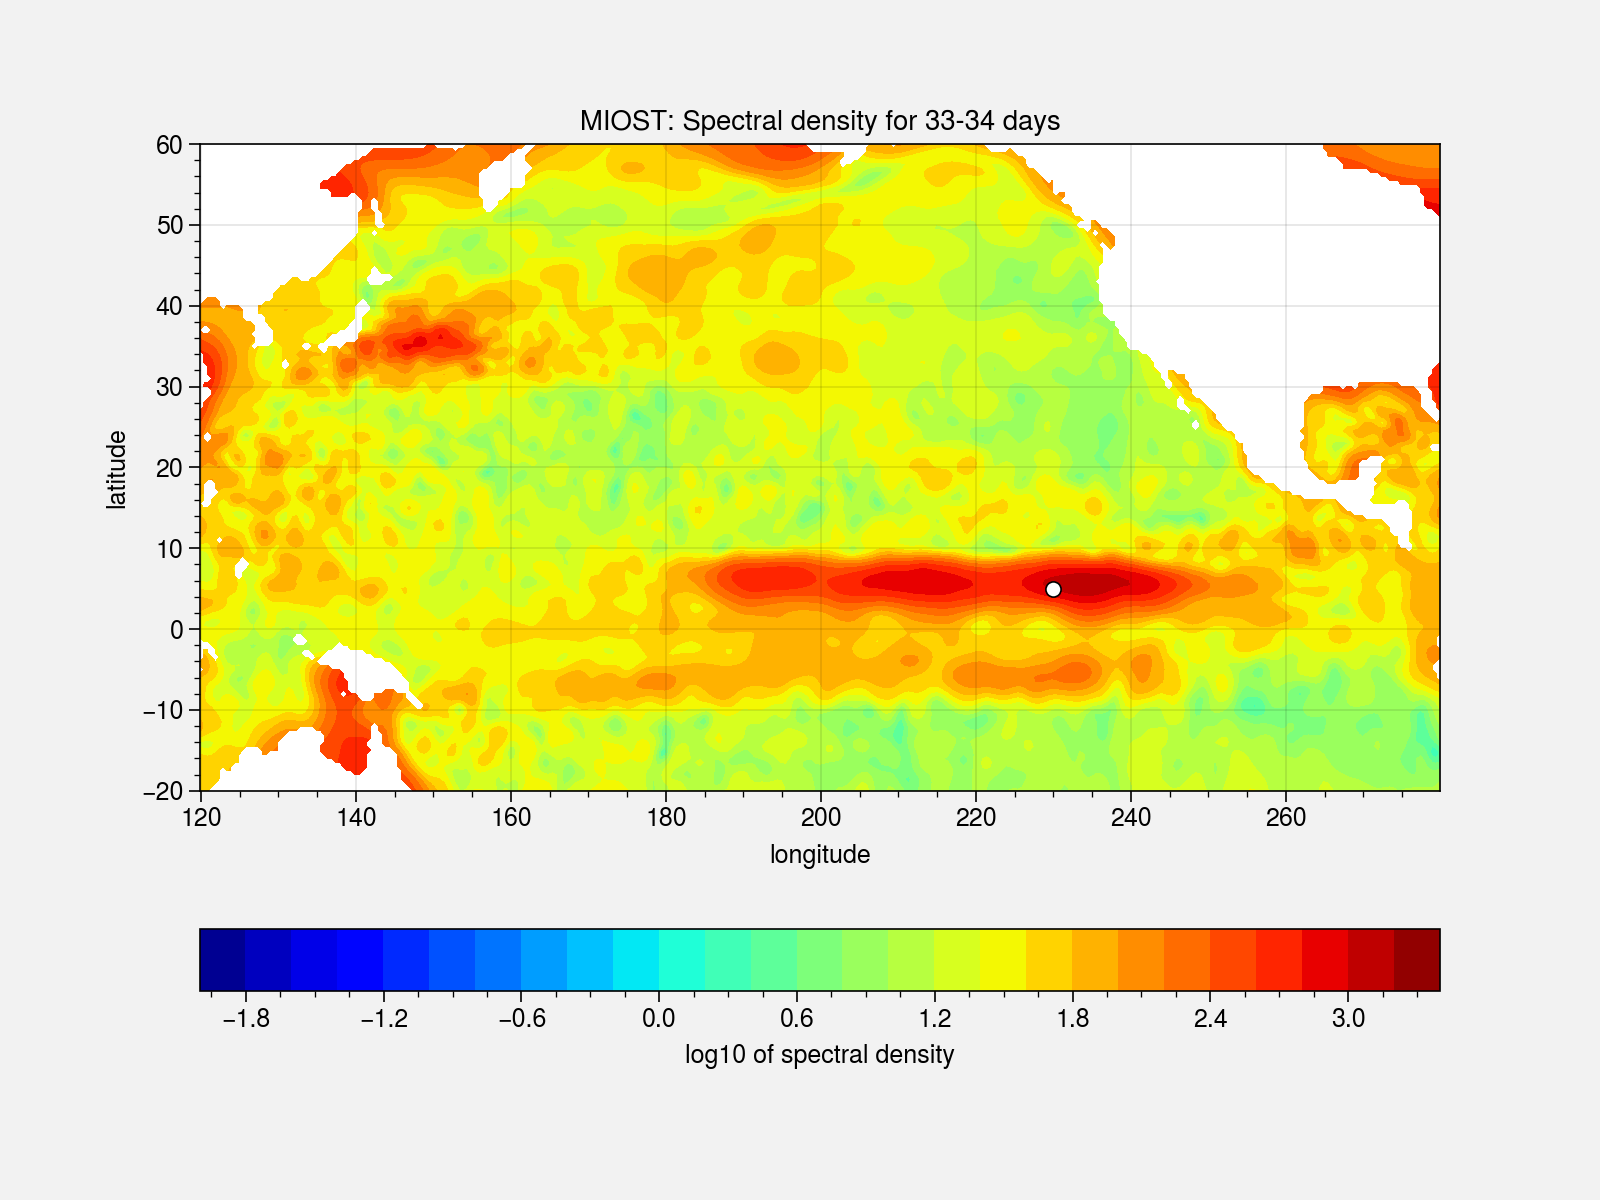

In [11]:
plot_psd_hh('psd_hh_adt_filtered400km_miost_20080101-20181231.nc', 'MIOST: Spectral density for 33-34 days', 'psd_hh_MIOST.png')

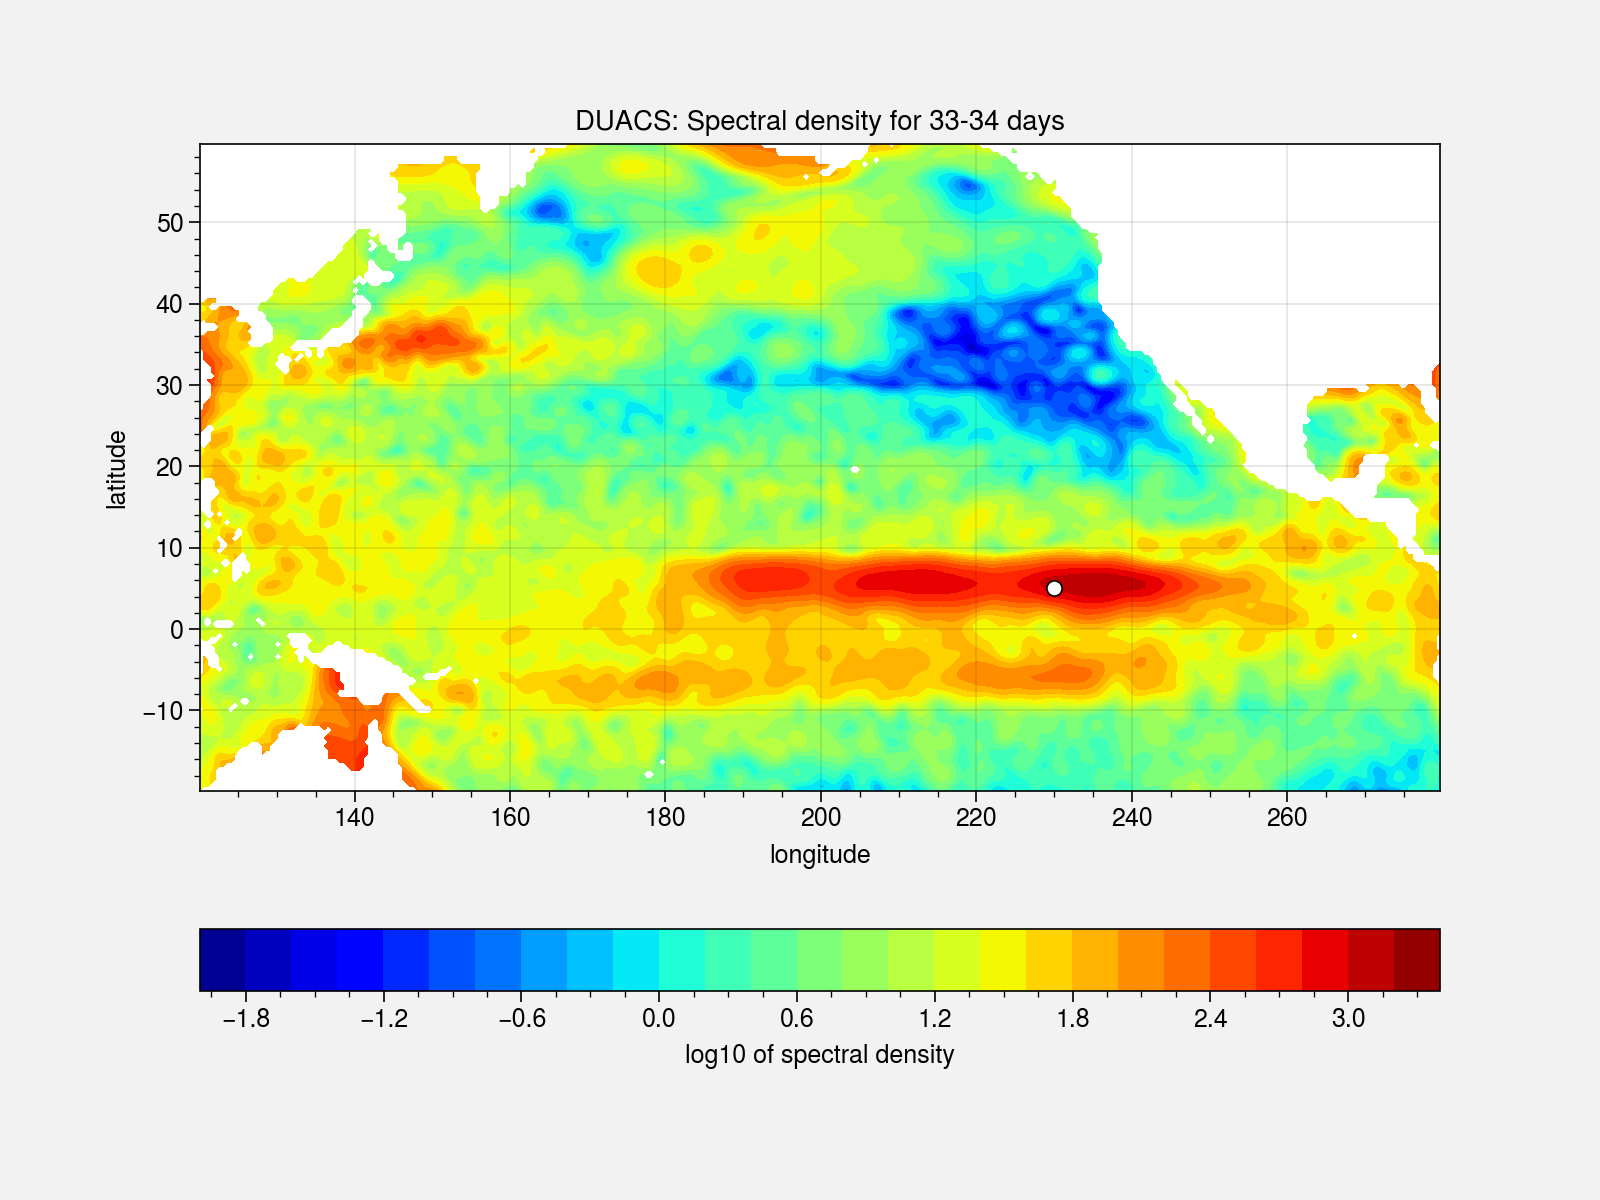

In [12]:
plot_psd_hh('psd_hh_adt_filtered400km_duacs_20080101-20181231.nc', 'DUACS: Spectral density for 33-34 days', 'psd_hh_DUACS.png')

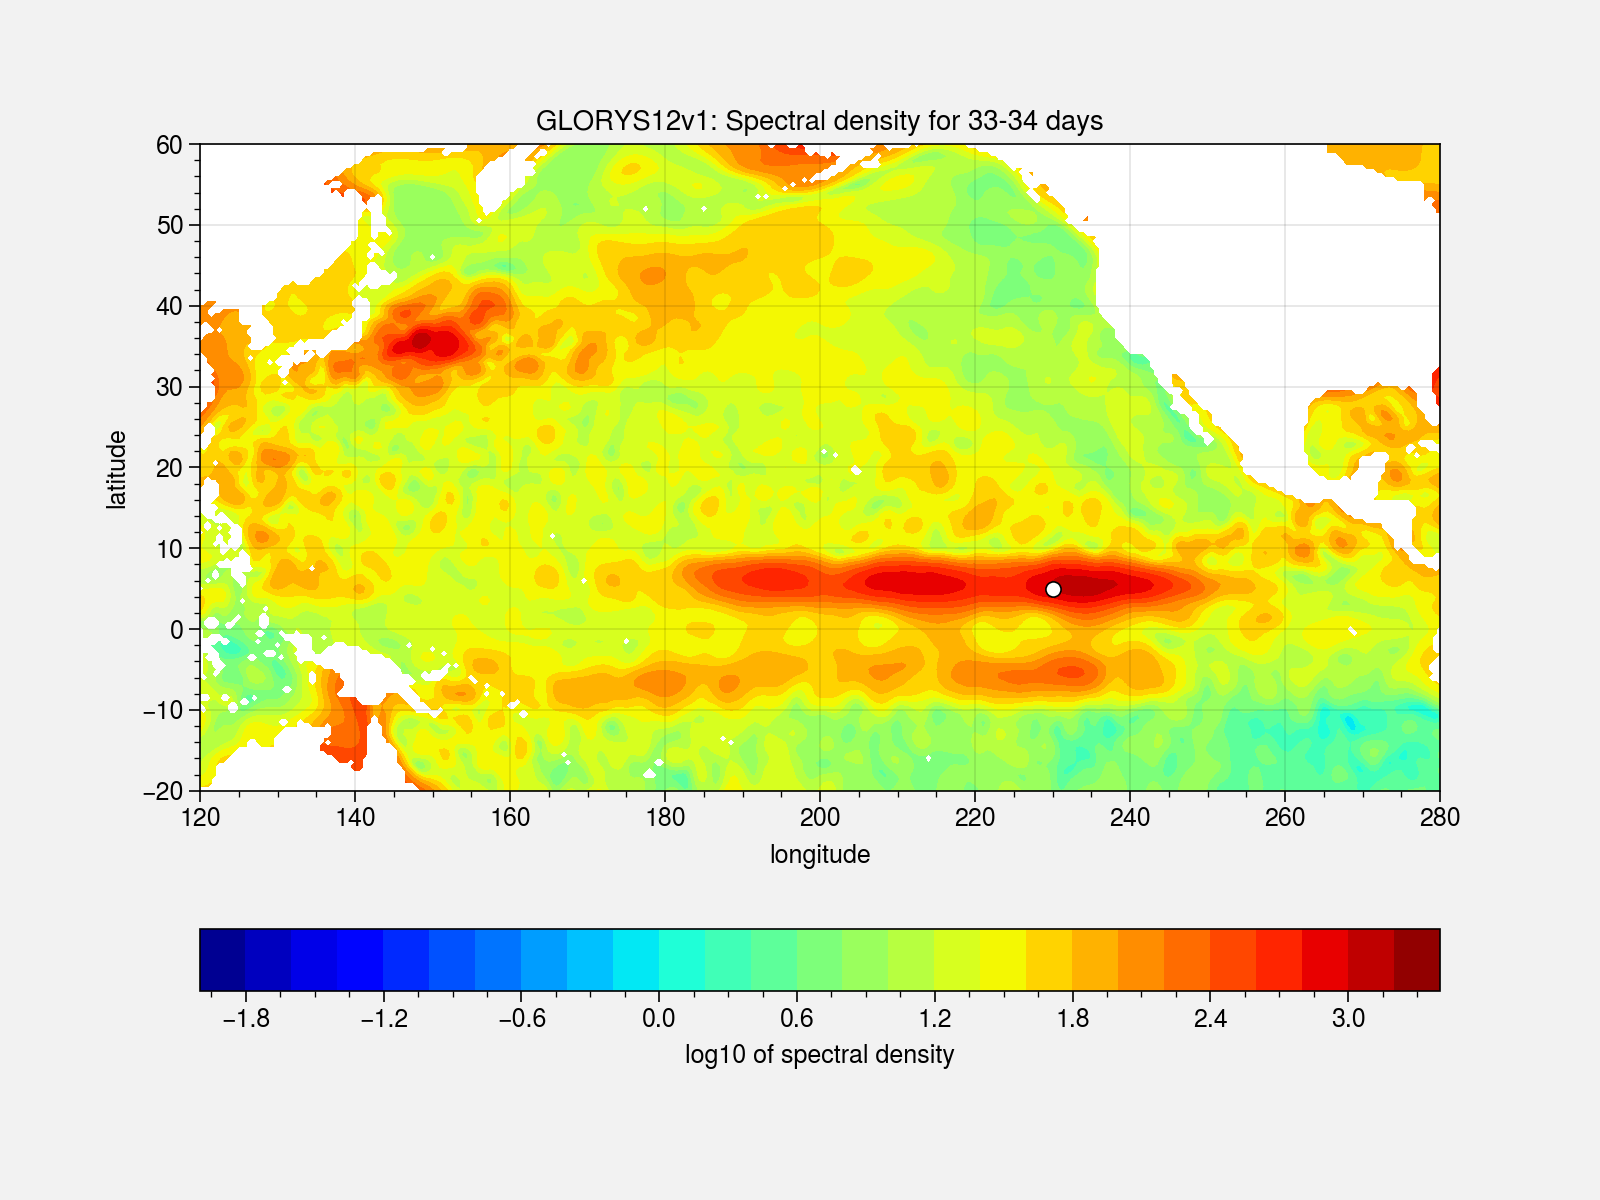

In [13]:
plot_psd_hh('psd_hh_adt_filtered400km_glorys12v1_20080101-20181231.nc', 'GLORYS12v1: Spectral density for 33-34 days', 'psd_hh_GLORYS12v1.png')

/data/MSA_ETU/mballarotta/conda_env/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


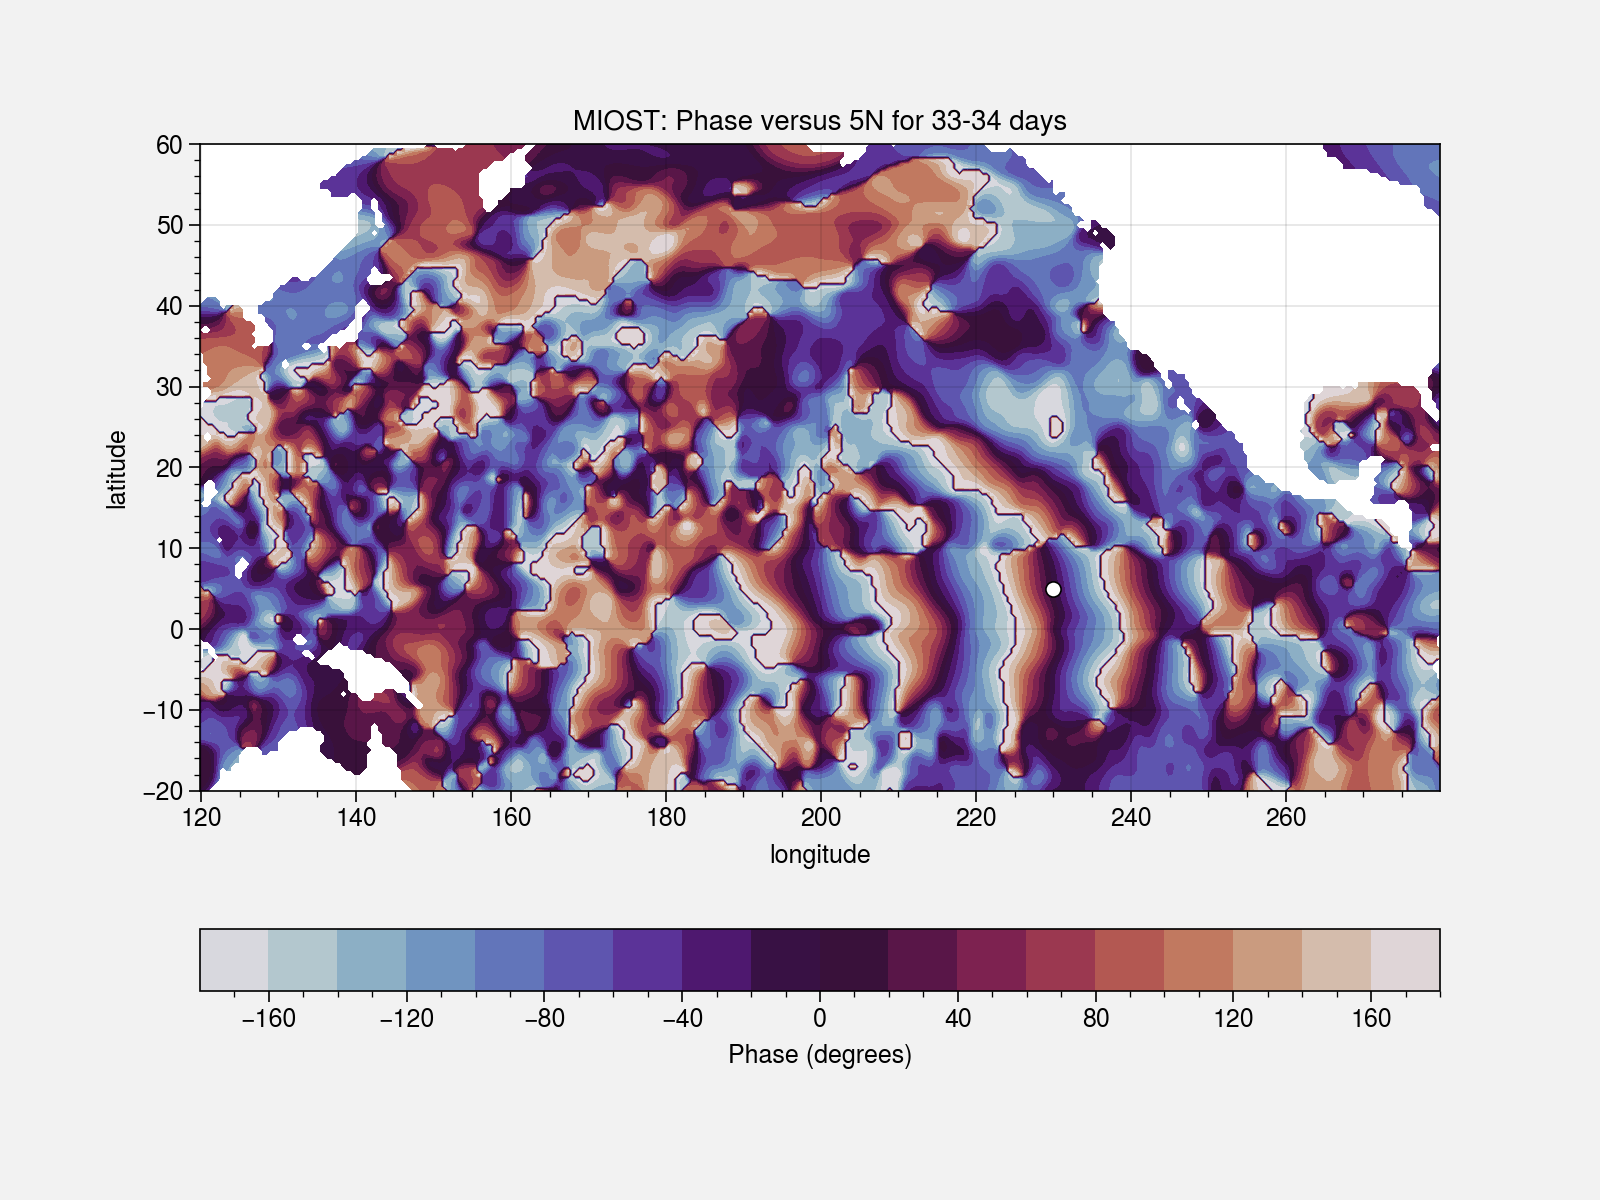

In [14]:
plot_cross_phase('cross_spectrum_hh0_adt_filtered400km_miost_20080101-20181231.zarr', 
                 'psd_h0_5N_130W_adt_filtered400km_miost_20080101-20181231.nc', 
                 'MIOST: Phase versus 5N for 33-34 days',
                 'Phase_vs_5N_MIOST.png')

/data/MSA_ETU/mballarotta/conda_env/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


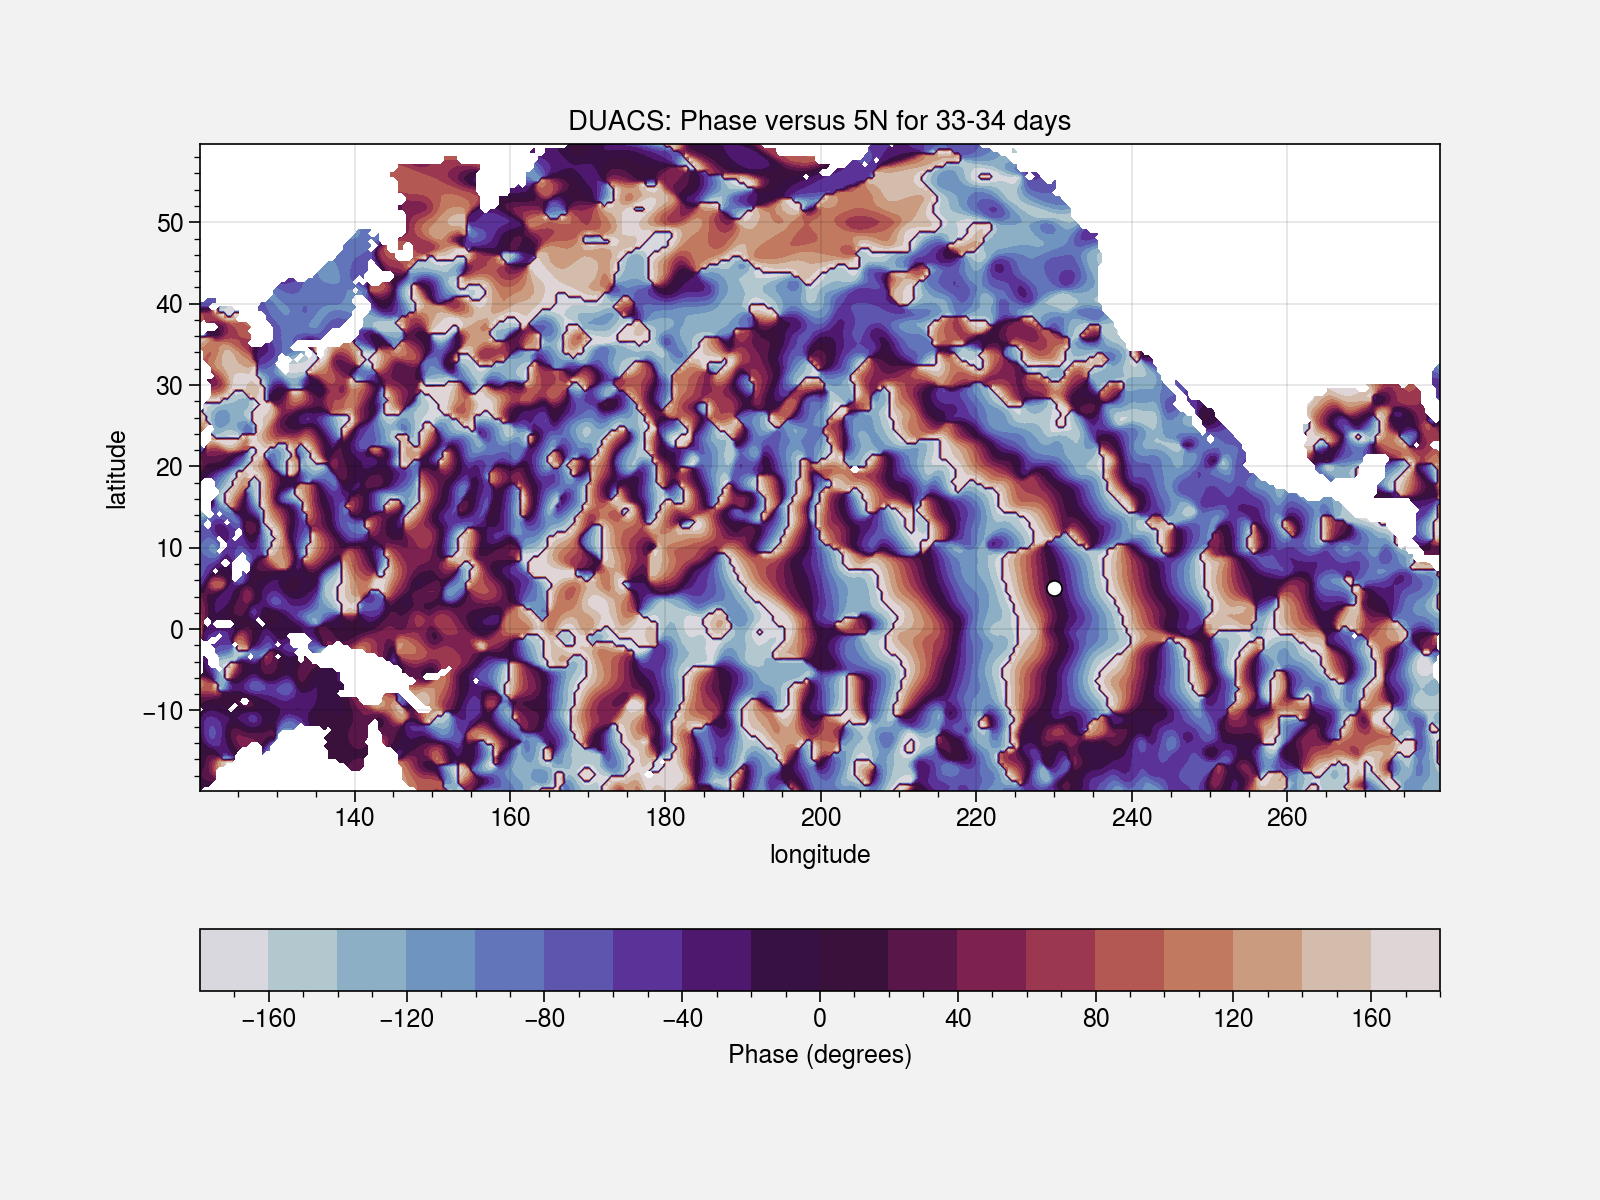

In [15]:
plot_cross_phase('cross_spectrum_hh0_adt_filtered400km_duacs_20080101-20181231.zarr', 
                 'psd_h0_5N_130W_adt_filtered400km_duacs_20080101-20181231.nc', 
                 'DUACS: Phase versus 5N for 33-34 days',
                 'Phase_vs_5N_DUACS.png')

/data/MSA_ETU/mballarotta/conda_env/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


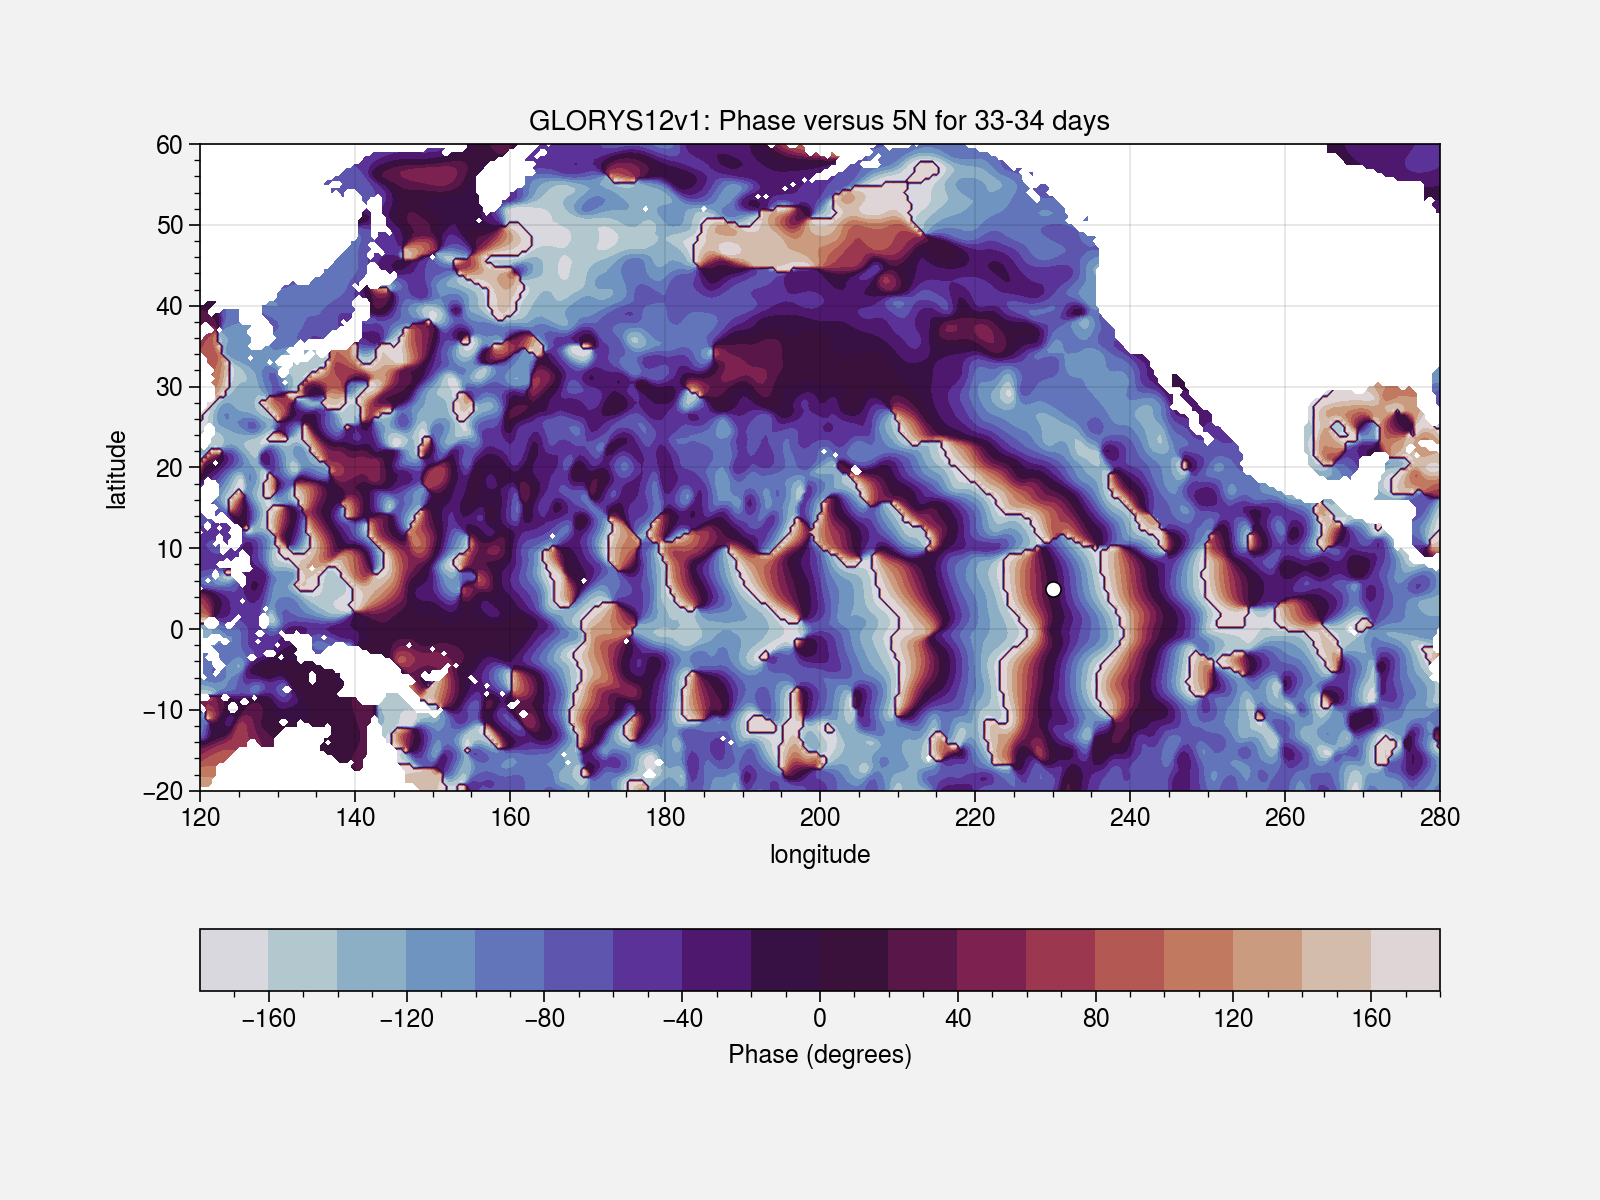

In [16]:
plot_cross_phase('cross_spectrum_hh0_adt_filtered400km_glorys12v1_20080101-20181231.zarr', 
                 'psd_h0_5N_130W_adt_filtered400km_glorys12v1_20080101-20181231.nc', 
                 'GLORYS12v1: Phase versus 5N for 33-34 days',
                 'Phase_vs_5N_GLORYS12v1.png')

/data/MSA_ETU/mballarotta/conda_env/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


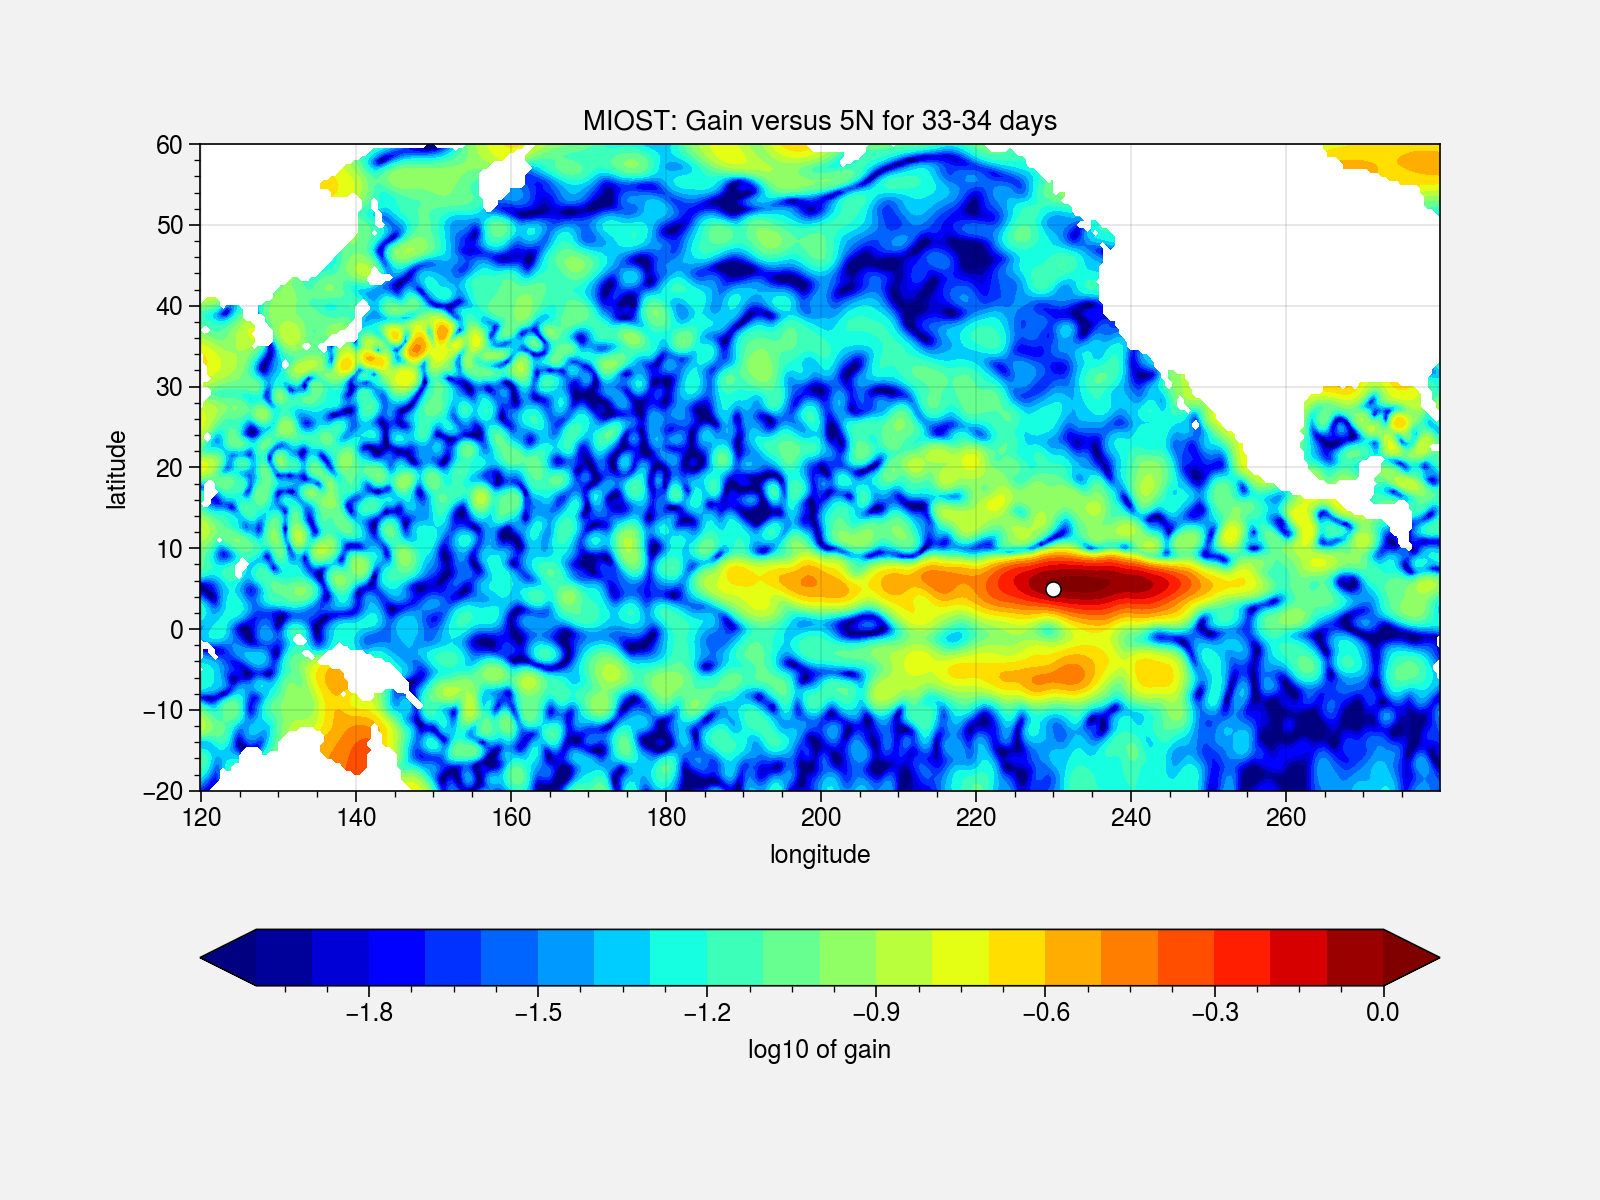

In [17]:
plot_gain('cross_spectrum_hh0_adt_filtered400km_miost_20080101-20181231.zarr', 
          'psd_h0_5N_130W_adt_filtered400km_miost_20080101-20181231.nc', 
          'MIOST: Gain versus 5N for 33-34 days',
          'Gain_vs_5N_MIOST.png')

/data/MSA_ETU/mballarotta/conda_env/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


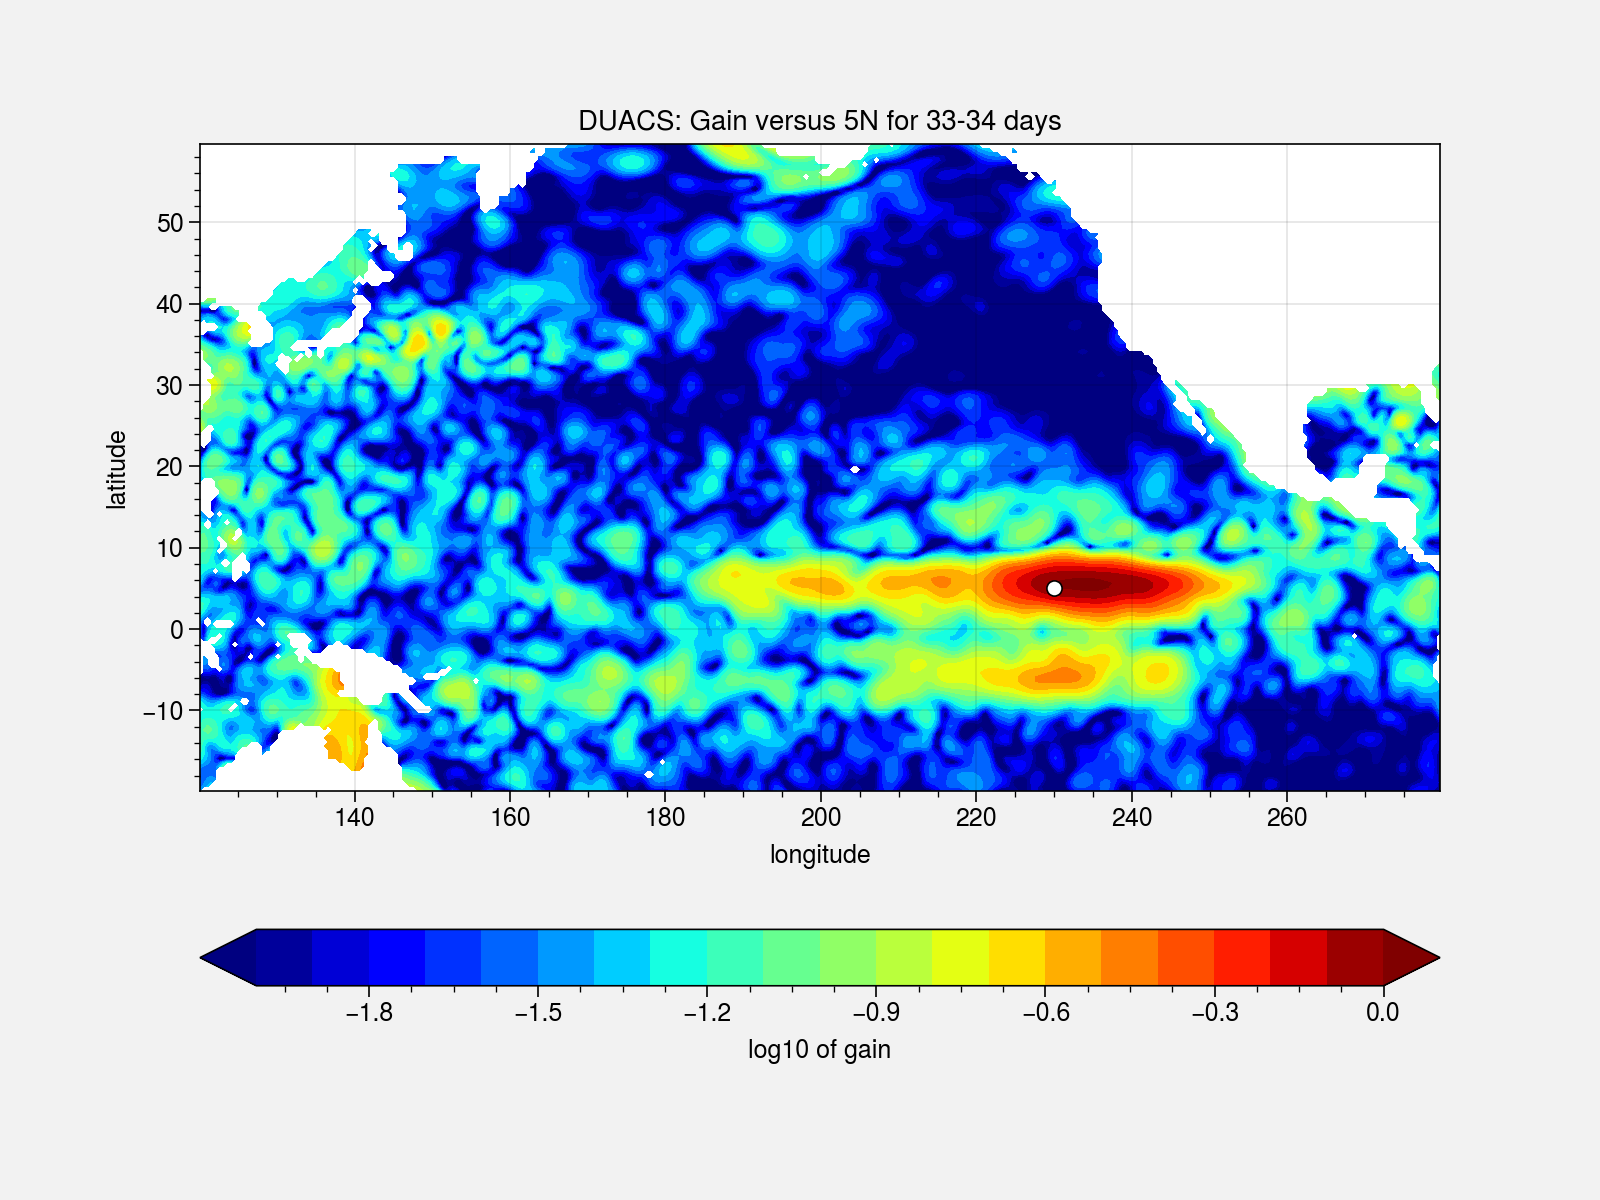

In [18]:
plot_gain('cross_spectrum_hh0_adt_filtered400km_duacs_20080101-20181231.zarr', 
          'psd_h0_5N_130W_adt_filtered400km_duacs_20080101-20181231.nc', 
          'DUACS: Gain versus 5N for 33-34 days',
          'Gain_vs_5N_DUACS.png')

/data/MSA_ETU/mballarotta/conda_env/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


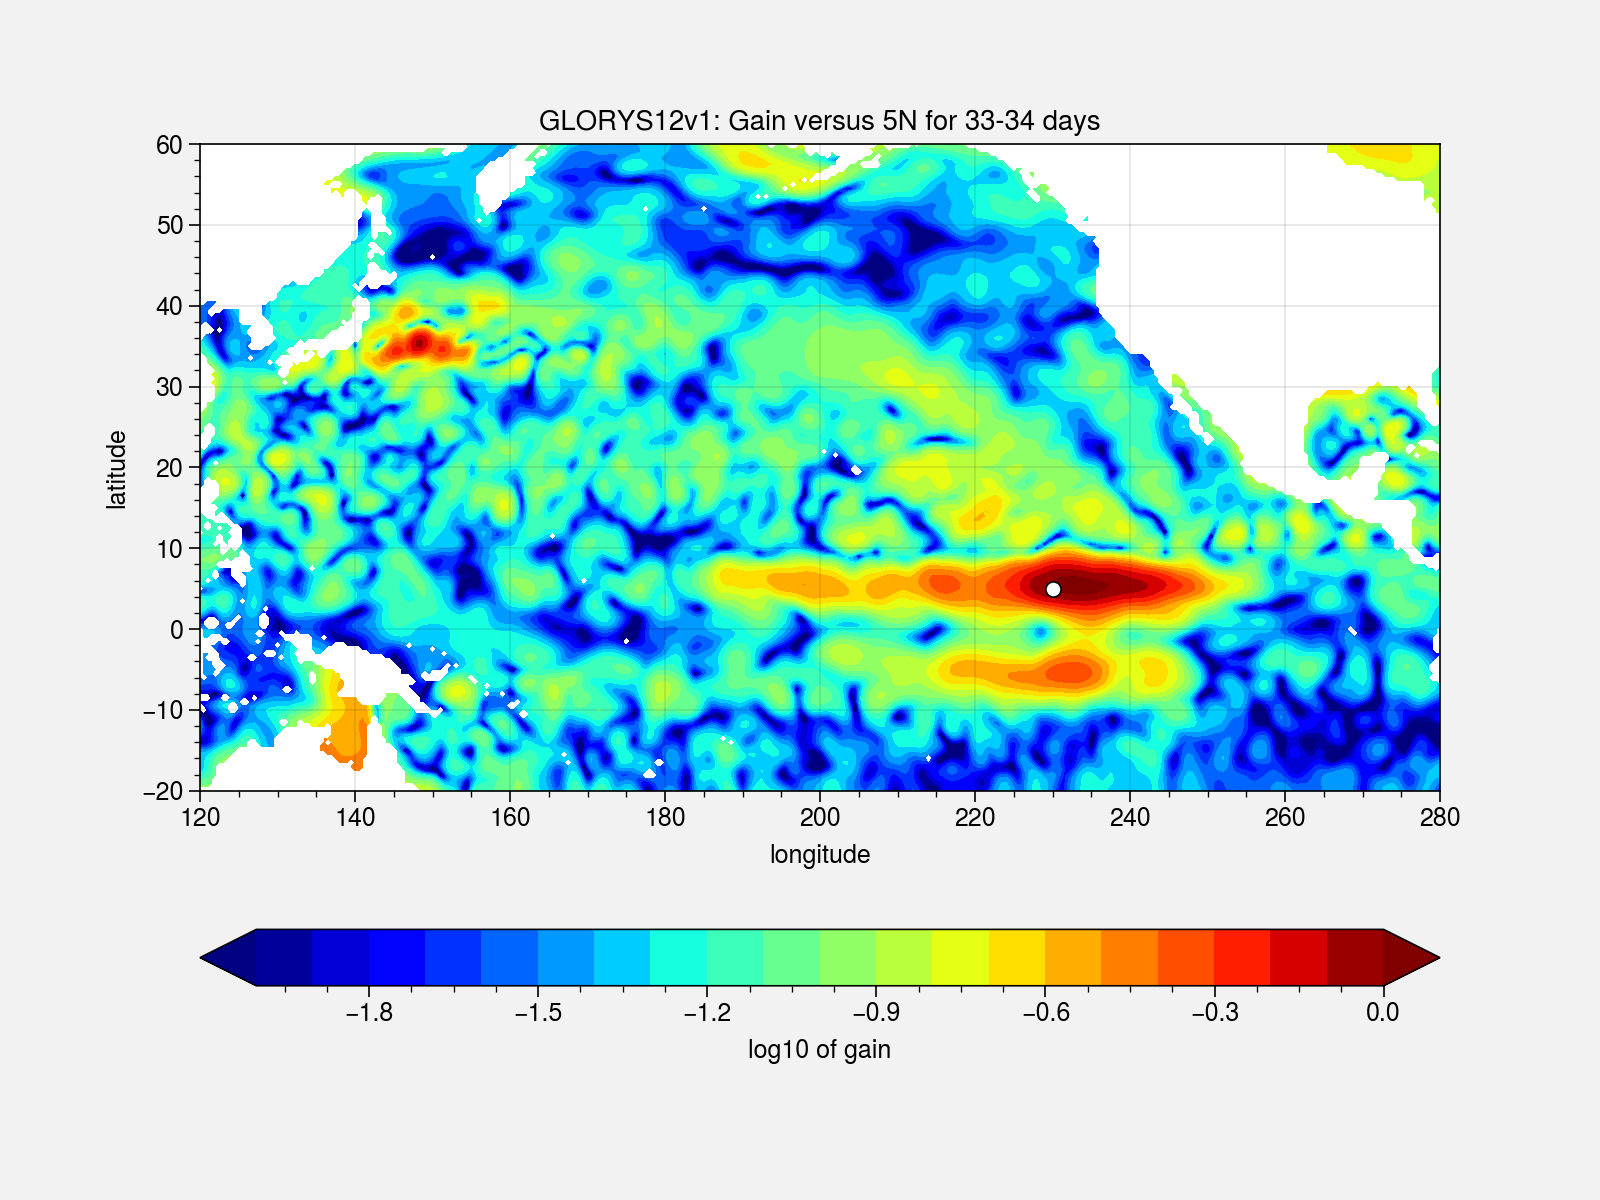

In [19]:
plot_gain('cross_spectrum_hh0_adt_filtered400km_glorys12v1_20080101-20181231.zarr', 
          'psd_h0_5N_130W_adt_filtered400km_glorys12v1_20080101-20181231.nc', 
          'GLORYS12v1: Gain versus 5N for 33-34 days',
          'Gain_vs_5N_GLORYS12v1.png')

/data/MSA_ETU/mballarotta/conda_env/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


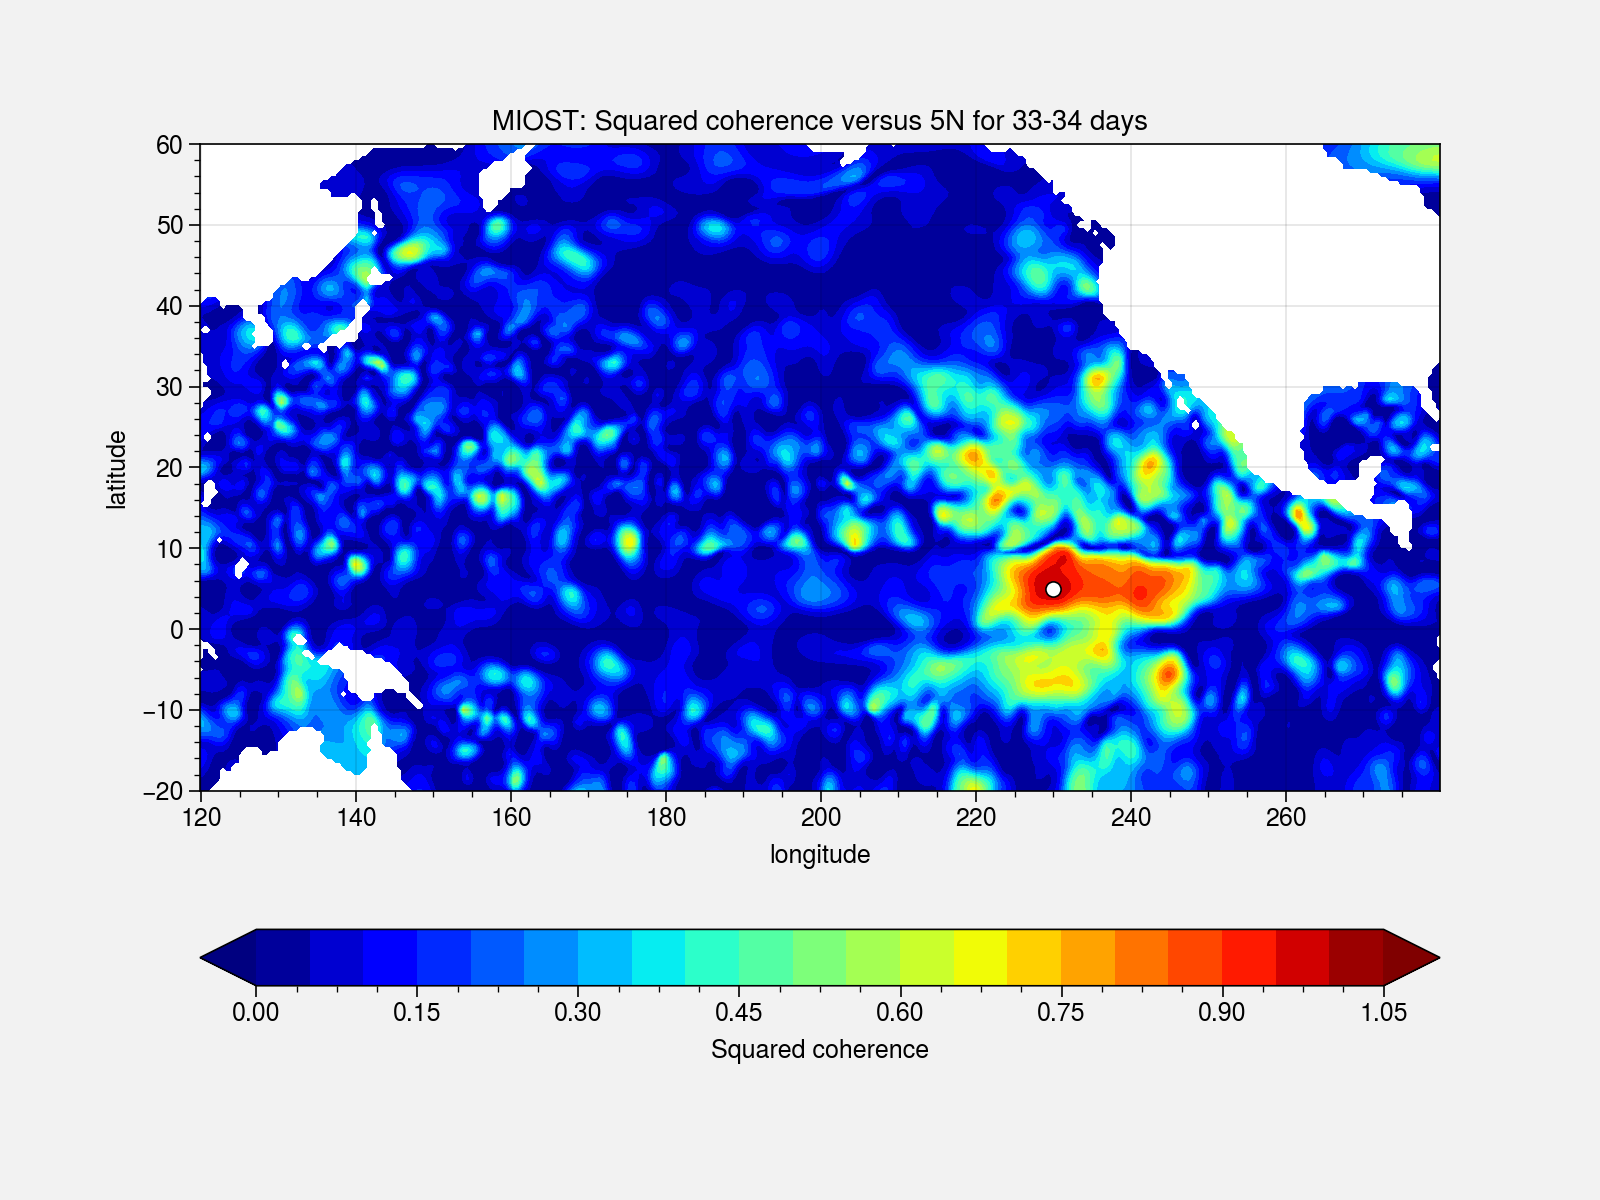

In [20]:
plot_coherence('cross_spectrum_hh0_adt_filtered400km_miost_20080101-20181231.zarr', 
               'psd_h0_5N_130W_adt_filtered400km_miost_20080101-20181231.nc',
               'psd_hh_adt_filtered400km_miost_20080101-20181231.nc',
               'MIOST: Squared coherence versus 5N for 33-34 days',
               'Coherence_vs_5N_MIOST.png')

/data/MSA_ETU/mballarotta/conda_env/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


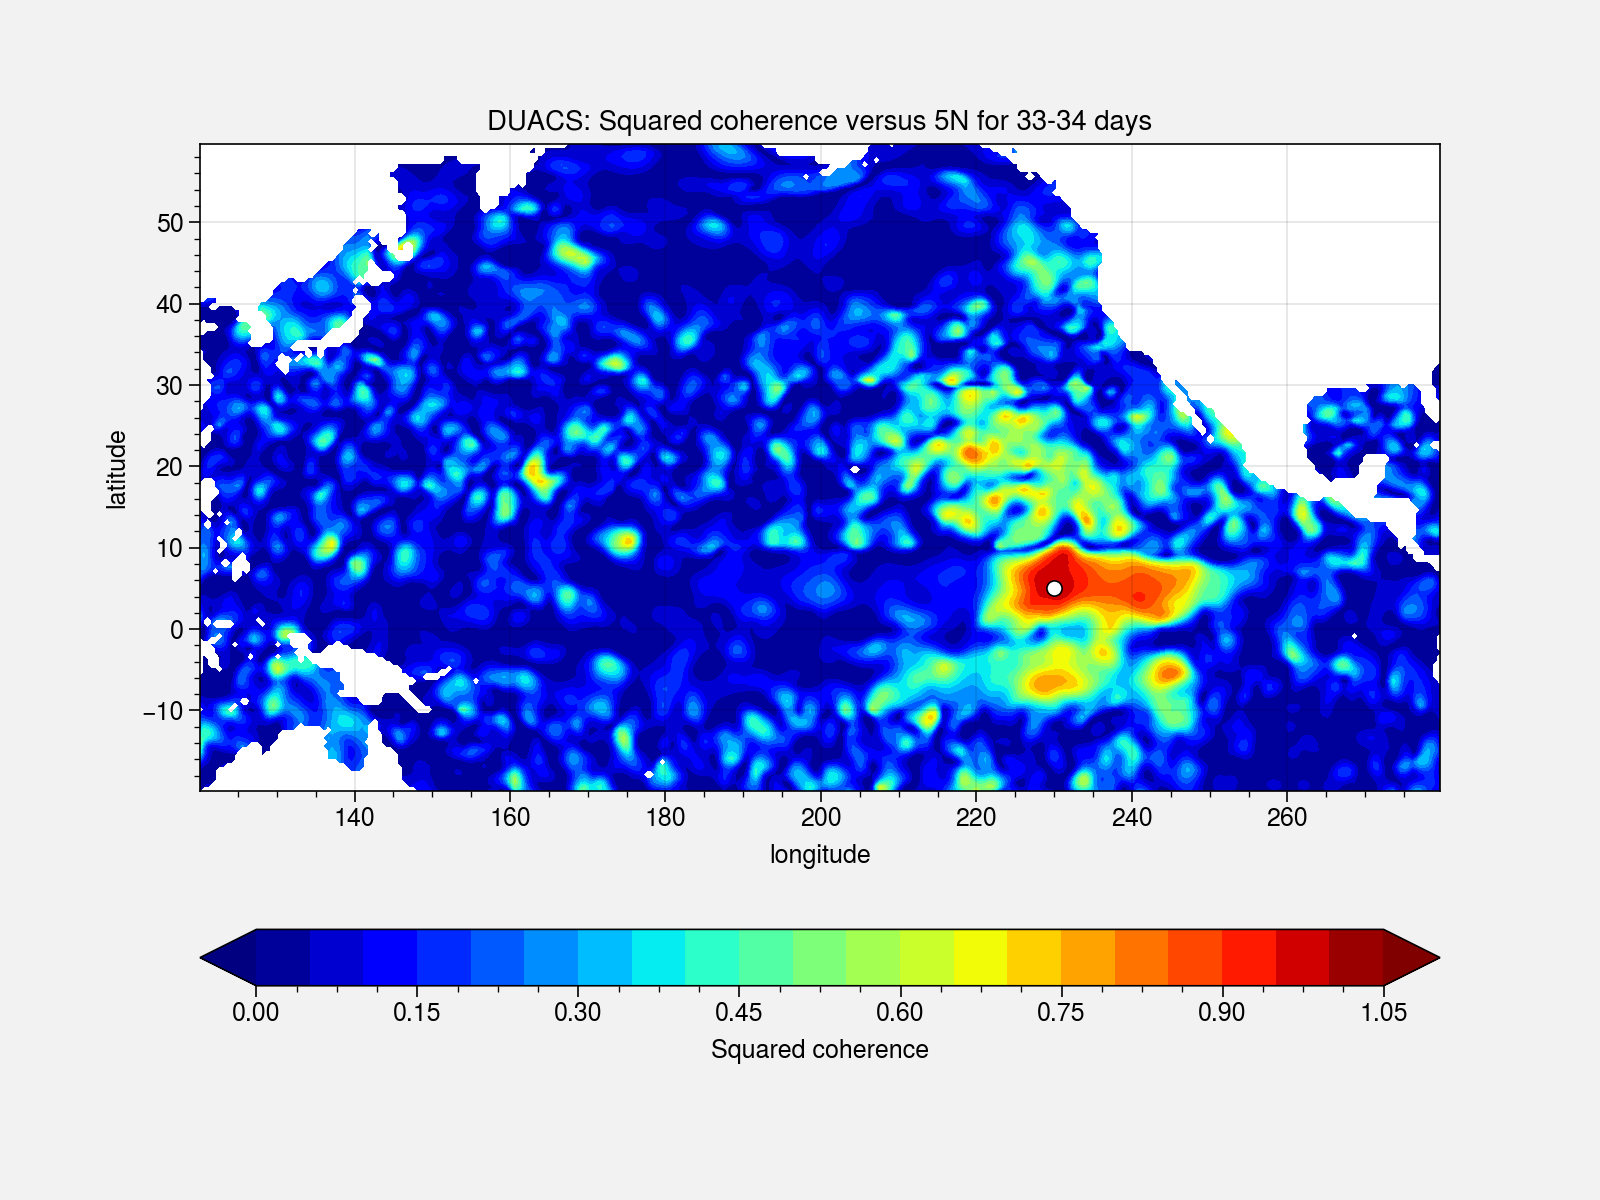

In [21]:
plot_coherence('cross_spectrum_hh0_adt_filtered400km_duacs_20080101-20181231.zarr', 
               'psd_h0_5N_130W_adt_filtered400km_duacs_20080101-20181231.nc',
               'psd_hh_adt_filtered400km_duacs_20080101-20181231.nc',
               'DUACS: Squared coherence versus 5N for 33-34 days',
               'Coherence_vs_5N_DUACS.png')

/data/MSA_ETU/mballarotta/conda_env/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


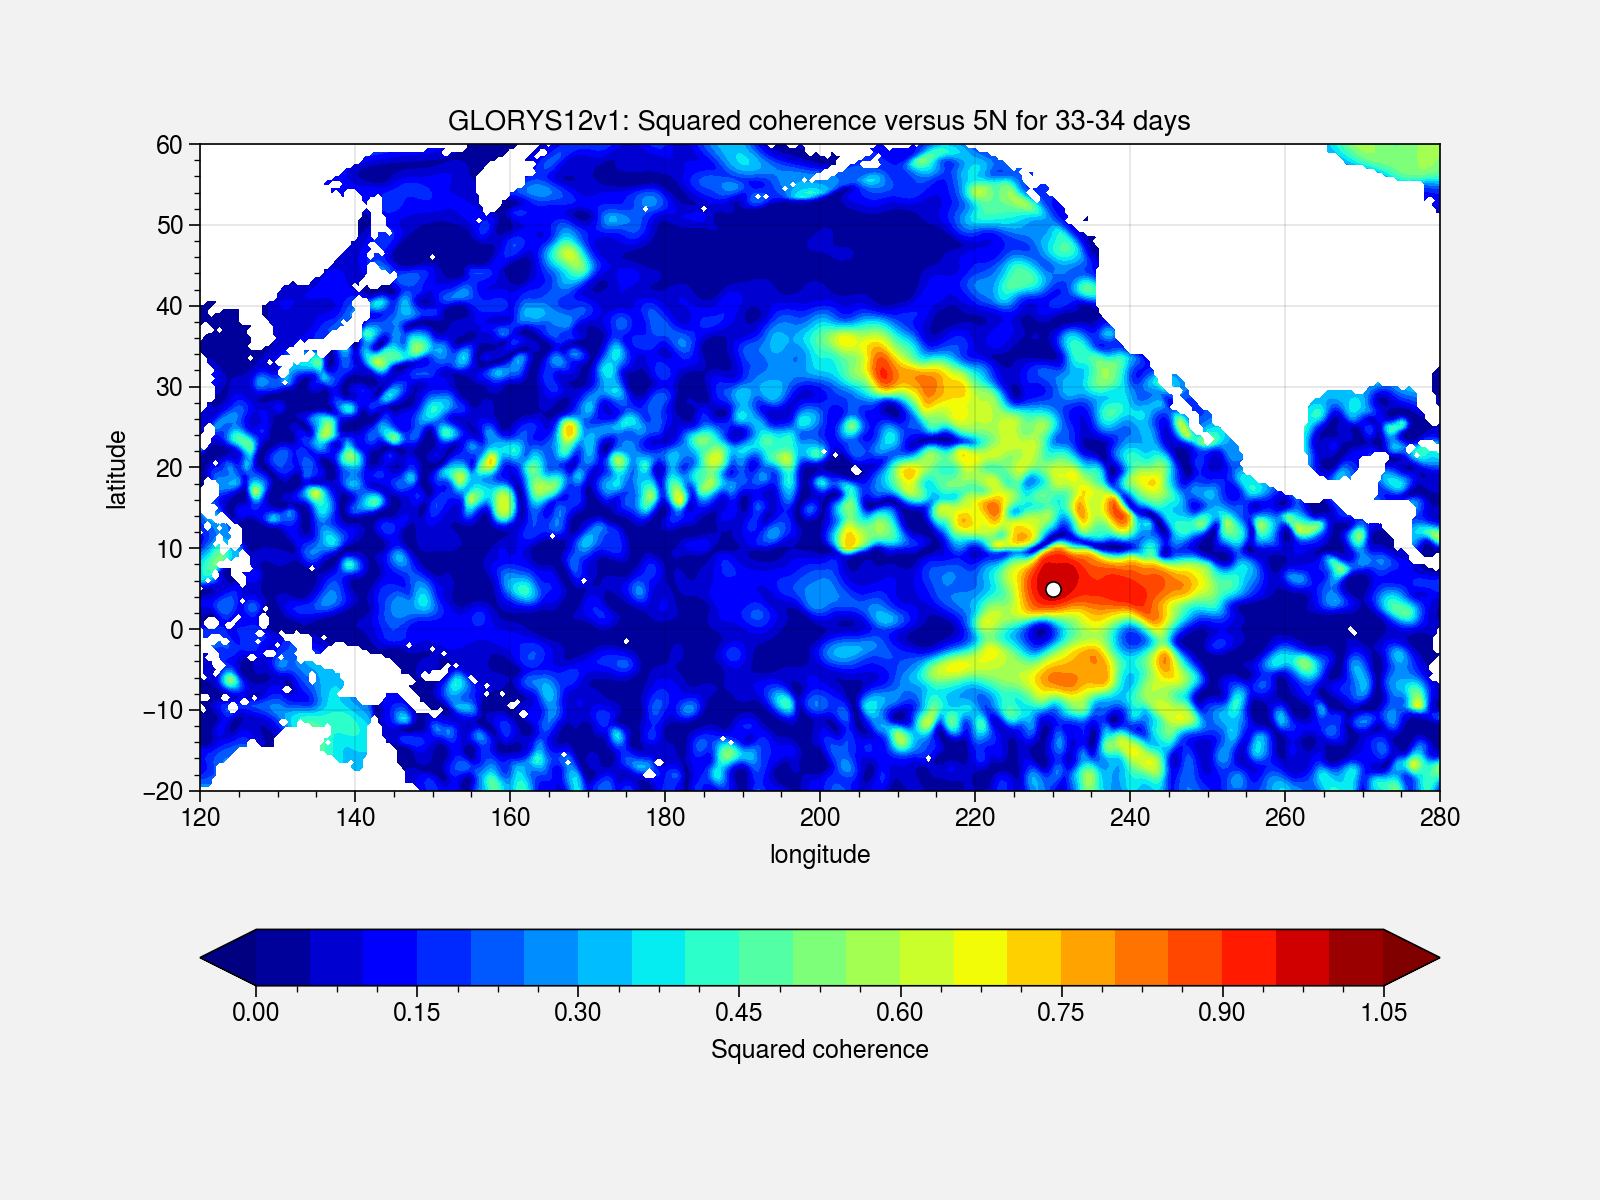

In [22]:
plot_coherence('cross_spectrum_hh0_adt_filtered400km_glorys12v1_20080101-20181231.zarr', 
               'psd_h0_5N_130W_adt_filtered400km_glorys12v1_20080101-20181231.nc',
               'psd_hh_adt_filtered400km_glorys12v1_20080101-20181231.nc',
               'GLORYS12v1: Squared coherence versus 5N for 33-34 days',
               'Coherence_vs_5N_GLORYS12v1.png')